# Imports and configuring a reproducibility seed

In [1]:
import os
import numpy as np
import random
import tensorflow as tf

seed = 1729959202

np.random.seed(seed)

random.seed(seed)

tf.random.set_seed(seed)

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam



gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)]
)

2024-11-09 19:46:01.736912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731177961.746424    5026 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731177961.749272    5026 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 19:46:01.759881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read data from I/O

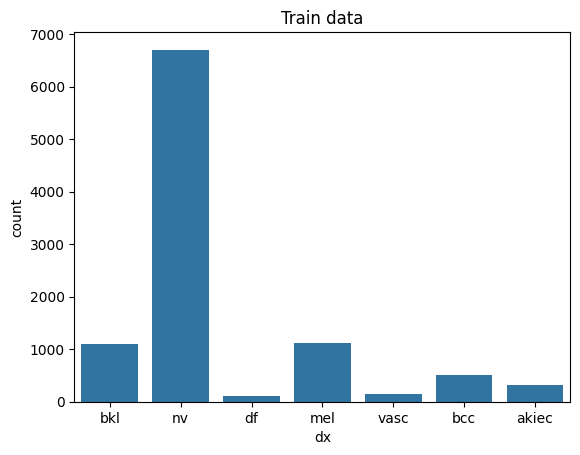

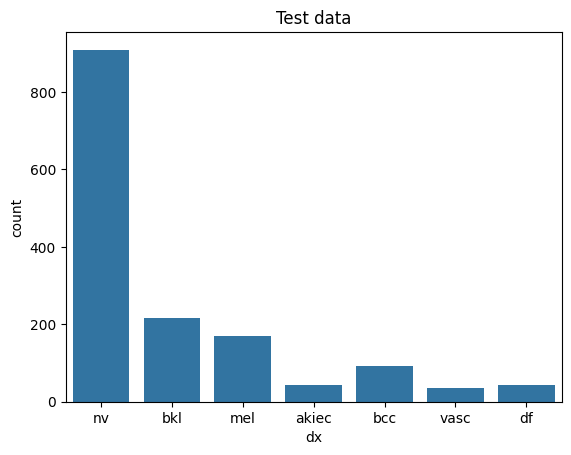

In [2]:
data_path = 'data/ham10000/HAM10000_metadata.csv'
df = pd.read_csv(data_path)

image_dir = 'data/ham10000/images/'  
test_image_dir = 'data/ham10000/images/test_images/'

df['image_path'] = image_dir + df['image_id'] + '.jpg'

df.head()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

sns.countplot(x='dx', data=df)
plt.title('Train data')
plt.show()

test_data_path = 'data/ham10000/images/ISIC2018_Task3_Test_GroundTruth.csv'

test_df = pd.read_csv(test_data_path)
test_df['image_path'] = test_image_dir + test_df['image_id'] + '.jpg'
test_df['label'] = label_encoder.transform(test_df['dx'])

sns.countplot(x='dx', data=test_df)
plt.title('Test data')
plt.show()

train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# Check for data leaks

In [ ]:
# Extract only the image name and extension for each set
train_set = set(os.path.basename(path) for path in train_df['image_path'])
val_set = set(os.path.basename(path) for path in val_df['image_path'])
test_set = set(os.path.basename(path) for path in test_df['image_path'])

# print the path of the first image in the training set and the test set
print("First image in the training set:", list(train_set)[0])
print("First image in the test set:", list(test_set)[0])



print("Overlaps between train and validation:", len(train_set.intersection(val_set)))
print("Overlaps between train and test:", len(train_set.intersection(test_set)))
print("Overlaps between validation and test:", len(val_set.intersection(test_set)))

First image in the training set: ISIC_0026110.jpg
First image in the test set: ISIC_0034980.jpg
Overlaps between train and validation: 0
Overlaps between train and test: 0
Overlaps between validation and test: 0


# Convert label to string for API compatibility

In [6]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Load and Augment Images and create tf.Data.Dataset instances for all parts of the data

In [7]:
image_size = (128, 128)
batch_size = 128
num_classes = len(df['dx'].unique())
img_height, img_width = image_size

def load_and_preprocess_image(image_path, label, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0  

    if augment:
        img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))  
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)

    return img, label

def create_dataset(df, augment=False, batch_size=32):
    df = df[df['image_path'].apply(os.path.exists)]
    
    image_paths = df['image_path'].values
    labels = df['label'].values
    labels = tf.keras.utils.to_categorical(labels, num_classes)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def preprocess_with_augment(image_path, label):
        return load_and_preprocess_image(image_path, label, augment)

    dataset = dataset.map(preprocess_with_augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

train_dataset = create_dataset(train_df, augment=True, batch_size=batch_size)
val_dataset = create_dataset(val_df, batch_size=batch_size)
# test_dataset = create_dataset(test_df, batch_size=batch_size)


I0000 00:00:1731178134.183437    5026 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7000 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout



def build_model(hp):
    conv_1_filters = hp.Int('conv_1_filters', min_value=32, max_value=256, step=32)
    conv_2_filters = hp.Int('conv_2_filters', min_value=32, max_value=128, step=32)
    conv_3_filters = hp.Int('conv_3_filters', min_value=32, max_value=64, step=16)
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])


    model = Sequential()
    input_shape = (128, 128, 3)
    model.add(Input(input_shape))
    model.add(Conv2D(
        filters=conv_1_filters,
        kernel_size=(2,2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=conv_2_filters,
        kernel_size=(2,2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=conv_3_filters,
        kernel_size=(2,2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(
        units=dense_units,
        activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax')) 

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=100, 
    directory='first_hyperparameter_search',
    project_name='cnn_bayesian_search',
    seed=seed)

Reloading Tuner from first_hyperparameter_search/cnn_bayesian_search/tuner0.json


In [9]:
tuner.search(
    train_dataset,
    epochs=20,
    validation_data=val_dataset)

Trial 100 Complete [00h 02m 33s]
val_accuracy: 0.7155688405036926

Best val_accuracy So Far: 0.7504990100860596
Total elapsed time: 13d 05h 18m 32s


In [10]:
# Create test_dataset
test_dataset = create_dataset(test_df, batch_size=batch_size)

In [ ]:


# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()


/home/bosa/manu/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 127, 127, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 96)     │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,725,895 (14.21 MB)

 Trainable params: 3,725,895 (14.21 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
tuner.get_best_hyperparameters()[0].values

{'conv_1_filters': 32,
 'conv_2_filters': 96,
 'conv_3_filters': 64,
 'dense_units': 256,
 'learning_rate': 0.000816846187274705,
 'activation': 'relu'}

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.7098 - loss: 0.8427
Test Accuracy: 0.6770350933074951


2024-11-09 20:20:08.829356: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Best model OVO AUC: 0.8654127899830218
Best model OVR AUC: 0.8654127899830218
Best model F1 Score: 0.6328456255935562


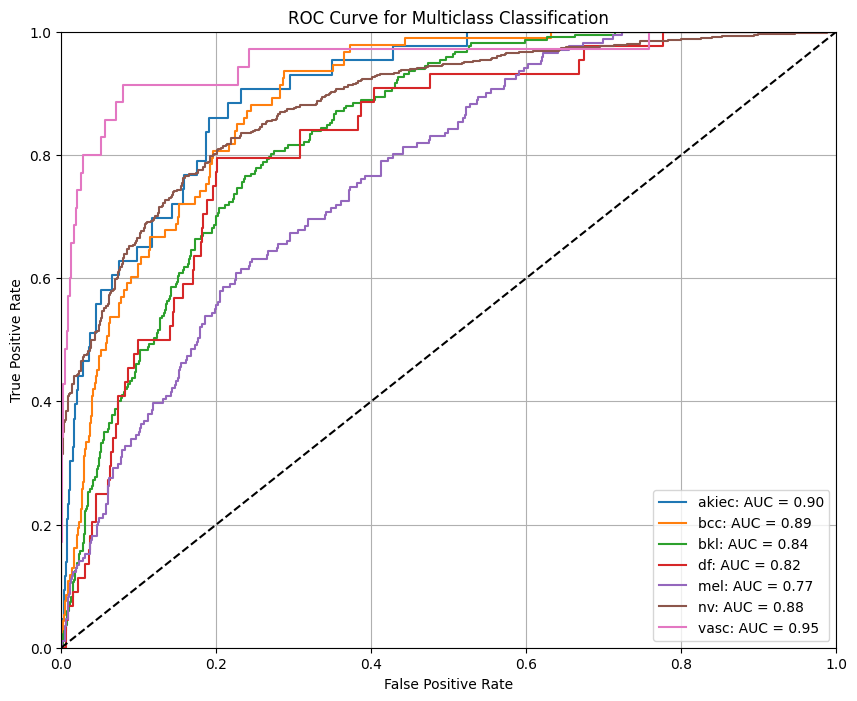

In [13]:
# Evaluate the best model on the test dataset
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc}')

# Calculate AUC and F1 scores
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_score = best_model.predict(test_dataset)

baseline_ovo_auc = roc_auc_score(y_true, y_score, multi_class="ovo")
baseline_ovr_auc = roc_auc_score(y_true, y_score, multi_class="ovr")
baseline_f1_score = f1_score(y_true.argmax(axis=1), y_score.argmax(axis=1), average="weighted")

print(f'Best model OVO AUC: {baseline_ovo_auc}')
print(f'Best model OVR AUC: {baseline_ovr_auc}')
print(f'Best model F1 Score: {baseline_f1_score}')

# Plot ROC curves
y_true = to_categorical(np.argmax(y_true, axis=1), num_classes)
class_names = label_encoder.inverse_transform(np.arange(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]}: AUC = {roc_auc[i]:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()